In [5]:
import biclustlib as biclustlib

In [6]:
#Biclustlib utilized R-wrappers for some algorithms, including the iterative Signature Algorithm. 
#First, go to R console and install packages "isa2" and "biclust"

#Now add R to the system Path

import sys
sys.path.append("C:\Program Files\R\R-4.3.1\bin")
sys.path.append("C:\Program Files\R\R-4.3.1\bin\x64")

#Define R_HOME to be used by rpy
import os
os.environ['R_HOME'] = "C:\Program Files\R\R-4.3.1"


In [7]:
#import the biclustlib algorithms
#The wrappers required R to be linked, and the packages "isa2" and "biclust" to be installed in R. 

from biclustlib.algorithms import *
from biclustlib.algorithms.wrappers import *

In [8]:
#TGCA Cancer DATSET 
#Need to download the python package from http://liuzlab.org/TCGA2STAT/   ----Link at the bottom
#Put the link to the package getTCGA file in the system path so that python knows where to look to find the package
import sys
sys.path.append("C:\\Users\\dsalina2\\Downloads\\tcga2stat_python_v2\\tcga2stat-python-v2.0\\getTCGA")

In [9]:
#important libraries 
import getTCGA as gt
import bs4
import re
import numpy
import requests
import pandas

In [10]:
#Obtain the dataset for Adrenal Cancer in RSEM RNA normalization. This functions connects to the BROAD institute Firehose,
# which makes available the Cancer Genome Atlas Data. 
ACC=gt.getTCGA(disease="ACC", clinical=True)
PCPG=gt.getTCGA(disease="PCPG", clinical=True)

getTCGA -  RNASeq2
dataset: ACC
dataType: RNASeq2
type: 
C:\Users\dsalina2\Downloads\tcga2stat_python_v2\tcga2stat-python-v2.0\getTCGA\
cvars: OS
getTCGA -  RNASeq2
dataset: PCPG
dataType: RNASeq2
type: 
C:\Users\dsalina2\Downloads\tcga2stat_python_v2\tcga2stat-python-v2.0\getTCGA\
cvars: OS


In [11]:
#Setting the merged clinical dataframe
clinicalPCPG=pandas.DataFrame(PCPG['clinical'][0])
clinicalACC=pandas.DataFrame(ACC['clinical'][0])

#Merging both dataframe
clinical=pandas.concat([clinicalPCPG, clinicalACC])

In [12]:
#We should remove the extra-adrenal cancers from analysis
#We only consider patients with cancer in adrenal gland

clinical1=clinical[clinical["tumortissuesite"]!="extra-adrenal site"]

In [13]:
#Get the cancer dataframes that has the Gene data as well as the patient status and Overall Survival
mergedPCPG=pandas.DataFrame(PCPG['merged_dat'][0])
mergedACC=pandas.DataFrame(ACC['merged_dat'][0])

#Concatenate both dataframes
merged1=pandas.concat([mergedPCPG, mergedACC])

In [14]:
#Selecting patients with both clinical and gene expression data

#reset index
merged1.set_index("bcr", inplace=True)

#Common patients in both df's
common=clinical1.index.intersection(merged1.index)

#Select the merged and clinical dataset with only the patients having both data
merged1=merged1.loc[common]
clinical1=clinical.loc[common]

In [17]:
#Removing columns of genes having more than 80% of expression lower than 5
#Bioinformatics practice as these low expression genes are not very informative.
for col in merged1.columns[2:]:
    if (merged1[col].astype(float)<5).sum() > (len(merged1)*0.8):
        merged1.drop(col, axis=1, inplace=True)

In [118]:
#arrange the data, to obtain only the GEX with Genes as rows and patients as cols
# This is the common output for biclustering algorithms
GEX=merged1.iloc[:,3:].astype(float)
GEX=GEX.transpose()

#Data incosistence indicated this patient has negative days, therefore the value was replaced
merged1['OS'].replace(-64, 64, inplace=True)

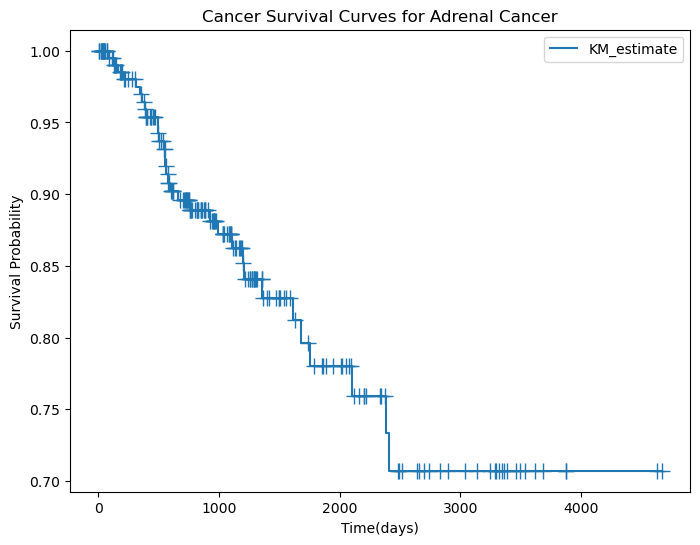

In [174]:
#Survival Curve of all the Patients with Adrenal Cancer
#Sample code modified from the lifelines package documentation
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

fig, ax=plt.subplots(figsize=(8,6))

kmf=KaplanMeierFitter()
kmf.fit(merged1["OS"], merged1["status"])
    
kmf.plot(ax=ax, ci_show=False, show_censors=True)

plt.title("Cancer Survival Curves for Adrenal Cancer")
plt.xlabel('Time(days)')
plt.ylabel("Survival Probability")
#plt.legend(title="Bicluster #")
plt.show()

<Axes: title={'center': 'Gender Distribution in Adrenal Cancer Dataset'}, ylabel='gender'>

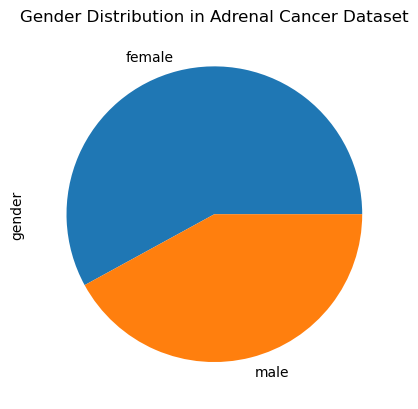

In [340]:
#Obtaining some feature distribution about the data
clinical1["gender"].value_counts().plot.pie(title="Gender Distribution in Adrenal Cancer Dataset")

<Axes: title={'center': 'Age Distribution of Adrenal Cancer Dataset'}, ylabel='Frequency'>

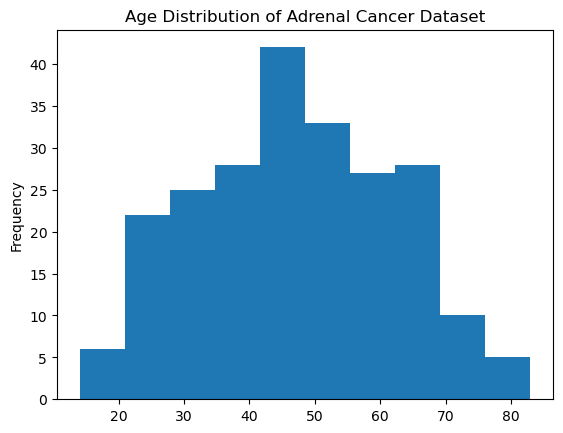

In [175]:
#Obtaining some feature distribution about the data
clinical1["yearstobirth"].astype(float).plot.hist(title="Age Distribution of Adrenal Cancer Dataset")

In [177]:
#Age Mean of the dataset
np.mean(clinical1["yearstobirth"].astype(float))

46.97787610619469

In [21]:
#Determining distribution of genes between each cluster
GEX_T["clust"]=list(clust_labs)
gene_means=GEX_T.groupby('clust')["SETD8"].mean()

plt.bar(gene_means.index,gene_means.values)
plt.xlabel("Cluster")
plt.ylabel("Mean Expression")
plt.title("Mean expression SETD8 per cluster")
plt.show()

NameError: name 'clust_labs' is not defined

In [86]:
import numpy as np
# Log2(x+1) normalization on rows, where rows are genes
GEX_norm_log = GEX.apply(lambda row: np.log2(row + 1), axis=1)


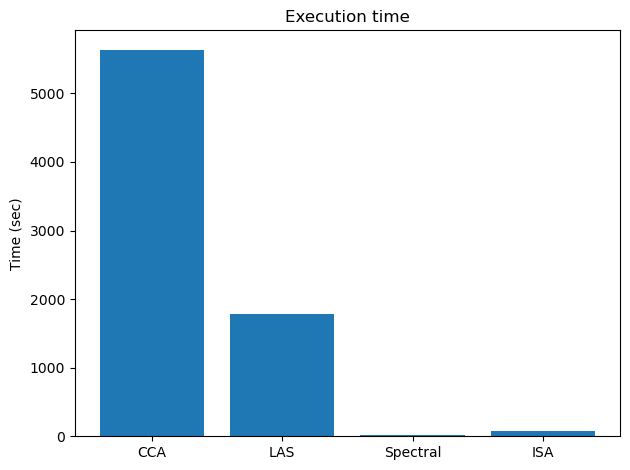

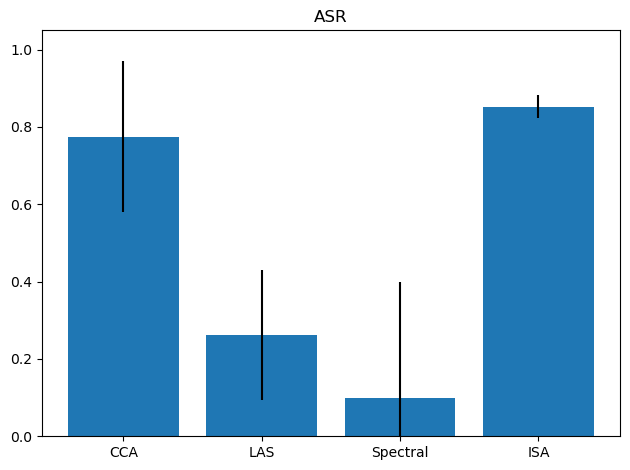

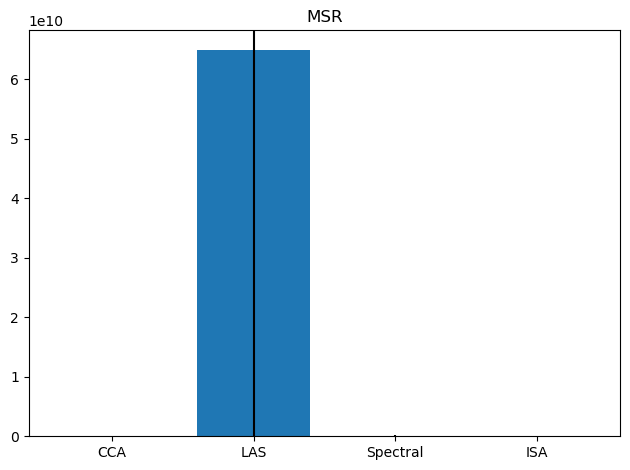

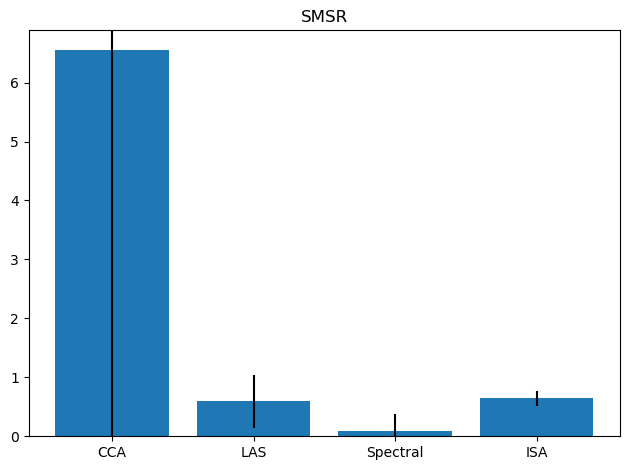

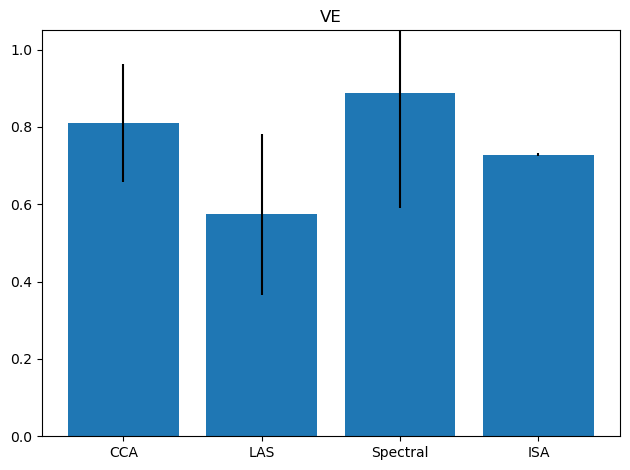

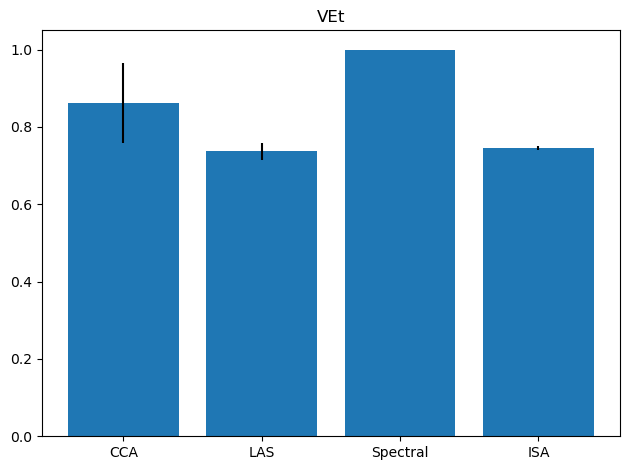

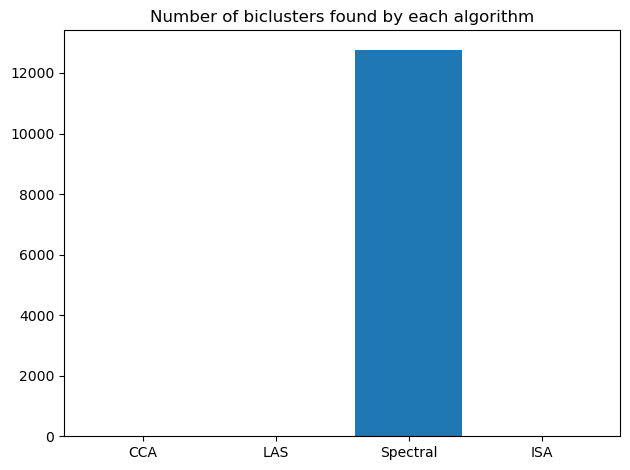

In [107]:
# Algorithm Benchmarking using our Gene expression data.
#Modification of the sample code from biclustlib for algorithm benchmarking
from biclustlib.benchmark import GeneExpressionBenchmark, Algorithm
from sklearn.preprocessing import KBinsDiscretizer
import multiprocessing
import pandas as pd

def discretize_data(raw_data: pd.DataFrame, n_bins: int = 2) -> pd.DataFrame:
    return pd.DataFrame(KBinsDiscretizer(n_bins, encode='ordinal', strategy='kmeans').fit_transform(raw_data),
                        index=raw_data.index).astype(int if n_bins > 2 else bool)


if __name__ == '__main__':
    
    data = GEX
    n_biclusters = 10
    reduction_level = 10
    discretion_level = 30

    data_dis = discretize_data(data, discretion_level)
    data_bin = discretize_data(data)

    setup = [
        Algorithm('CCA', ChengChurchAlgorithm(n_biclusters), data),
        Algorithm('LAS', LargeAverageSubmatrices(n_biclusters), data),
        Algorithm('Spectral', Spectral(n_clusters=data.shape[1] // 2), data + abs(data.min().min()) + 1),
        Algorithm('ISA', IterativeSignatureAlgorithm2(num_seeds=100, row_thr=0.5, col_thr=0.5), data)
    ]
    
    
    with multiprocessing.Pool() as pool:
        benchmark = GeneExpressionBenchmark(algorithms=setup,
                                                        raw_data=data,
                                                        reduction_level=reduction_level).run(pool)
    benchmark.generate_report()

In [ ]:
#Testing multiple ISA2 parameters
#isa2 tests for Adrenal specific Cancer with filtered genes
#ISA function itselfs normalized both the rows in a row submatrix, and the columns in a column submatrix.
# Therefore we let ISA algorithm do the normalization

for rowt in [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.2, 1.5, 2]:
    for colt in [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.2, 1.5, 2]:
        isa=IterativeSignatureAlgorithm2(num_seeds=100, row_thr=rowt, col_thr=colt)
        isa2train=isa.run(GEX)
        print("###row threshold used " +str(rowt) + "####col thresh. used: " + str(colt))
        for bicluster in isa2train.biclusters:
            print("rowt "+str(rowt))
            print(len(bicluster.rows))
            print("colt "+str(colt))
            print(len(bicluster.cols))

In [127]:
#Running ISA2 Algorithm with best parameters obtained from hyperparametrization.
isa=IterativeSignatureAlgorithm2(num_seeds=100, row_thr=0.2, col_thr=0.4)
isa2norm=isa.run(GEX)

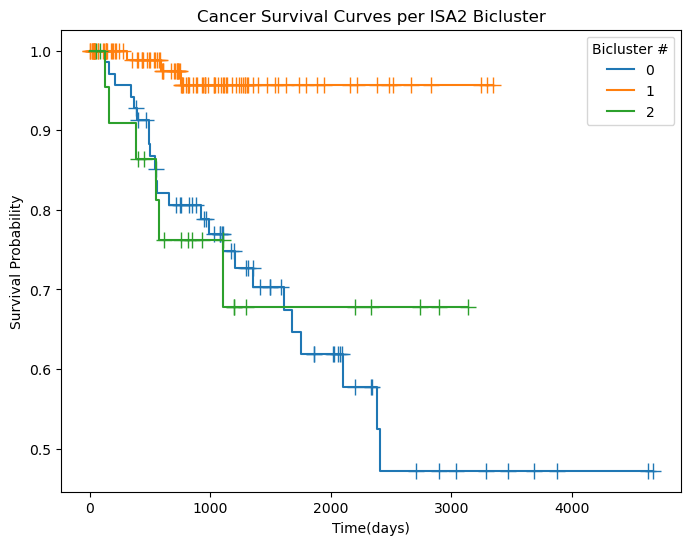

In [144]:
#The survival curves of each of the bicluster patients from the ISA algorithm 
#Survivals
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

fig, ax=plt.subplots(figsize=(8,6))
bicnum=0
for bic in isa2norm.biclusters:
    kmf=KaplanMeierFitter()
    kmf.fit(merged1.iloc[bic.cols]["OS"], merged1.iloc[bic.cols]["status"], label=bicnum)
    
    kmf.plot(ax=ax, ci_show=False, show_censors=True)
    
    bicnum+=1
plt.title("Cancer Survival Curves per ISA2 Bicluster")
plt.xlabel('Time(days)')
plt.ylabel("Survival Probability")
plt.legend(title="Bicluster #")
plt.show()

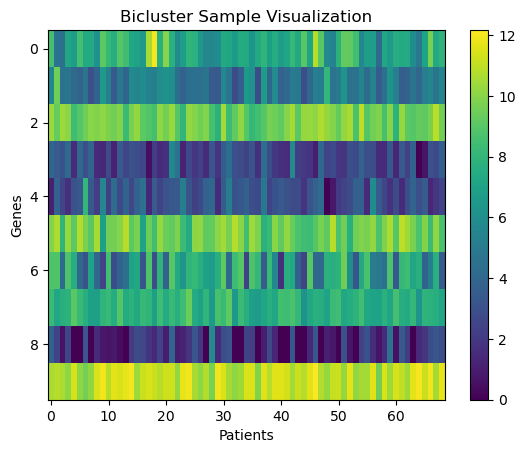

In [129]:

# Partial plotting of biclusters
biclustered_data = GEX_norm_log.iloc[list(isa2norm.biclusters[0].rows)[0:10], list(isa2norm.biclusters[0].cols)]

# Heatmap
plt.imshow(biclustered_data, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Bicluster Sample Visualization')
plt.xlabel('Patients')
plt.ylabel('Genes')
plt.show()

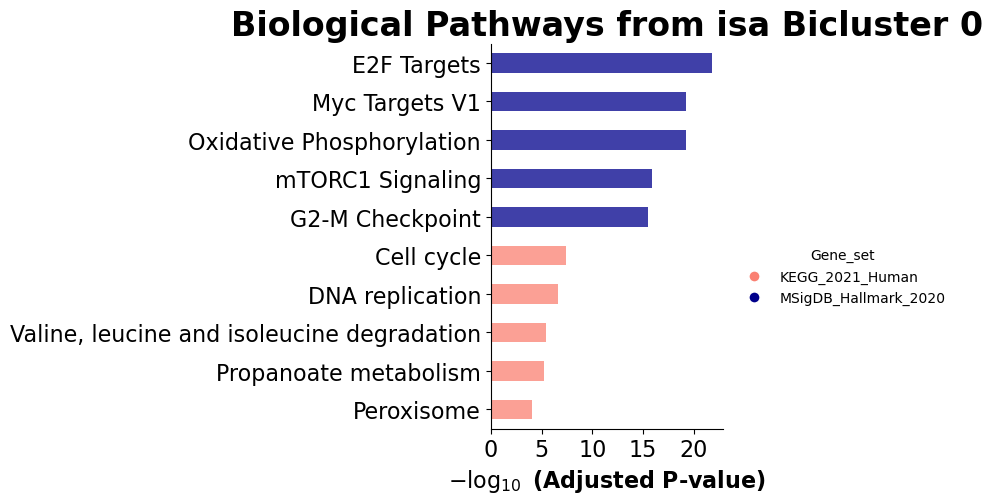

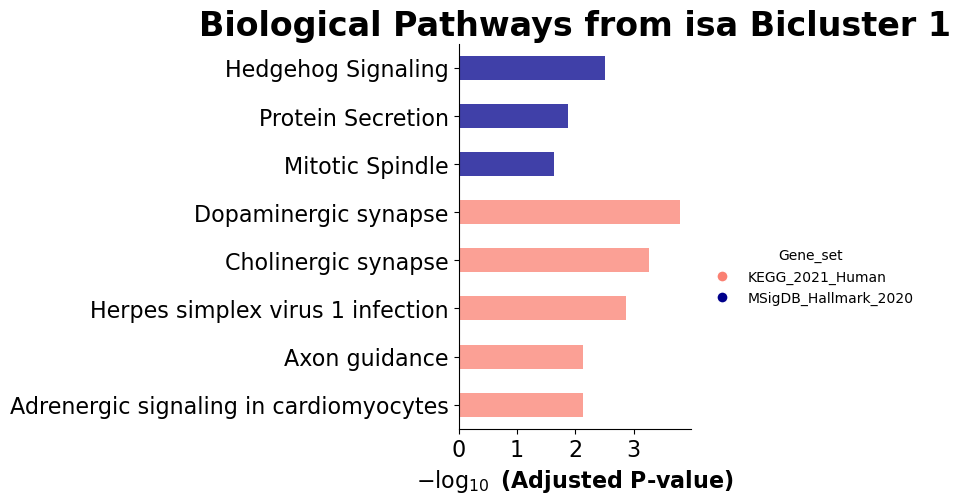

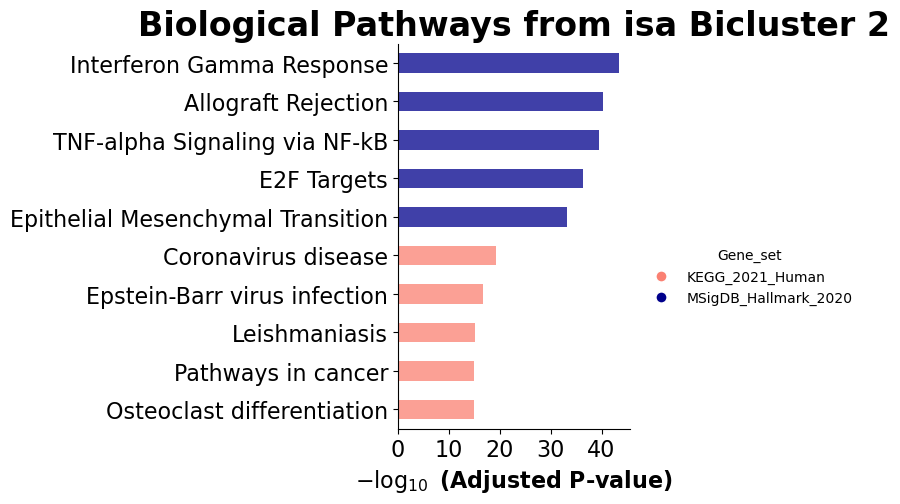

In [143]:
#Gene Set Enrichment analysis for the genes in each bicluster
#Code modified from gseapy documentation
from gseapy import enrichr
from gseapy import barplot, dotplot

for num in list(range(3)):
    try:
        enr = enrichr(gene_list=GEX.index[isa2norm.biclusters[num].rows].tolist(),
                         gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                         organism='human',
                         outdir=None, 
                        )

        # categorical scatterplot
        ax = barplot(enr.results,
                      column="Adjusted P-value",
                      group='Gene_set', 
                      size=10,
                      top_term=5,
                      figsize=(3,5),
                      color = {'KEGG_2021_Human': 'salmon', 'MSigDB_Hallmark_2020':'darkblue'},
                      title=("Biological Pathways from isa Bicluster "+ str(num))
                     )
    except:
            print("no motifs found in cluster" + str(num))

In [146]:
#Code to make biological pathway networks
#Code modified From gseapy documentation
enr = enrichr(gene_list=GEX.index[isa2norm.biclusters[2].rows].tolist(),
                         gene_sets=['KEGG_2021_Human', 'MSigDB_Hallmark_2020'],
                         organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                         outdir=None, 
                        )

C:\ProgramData\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


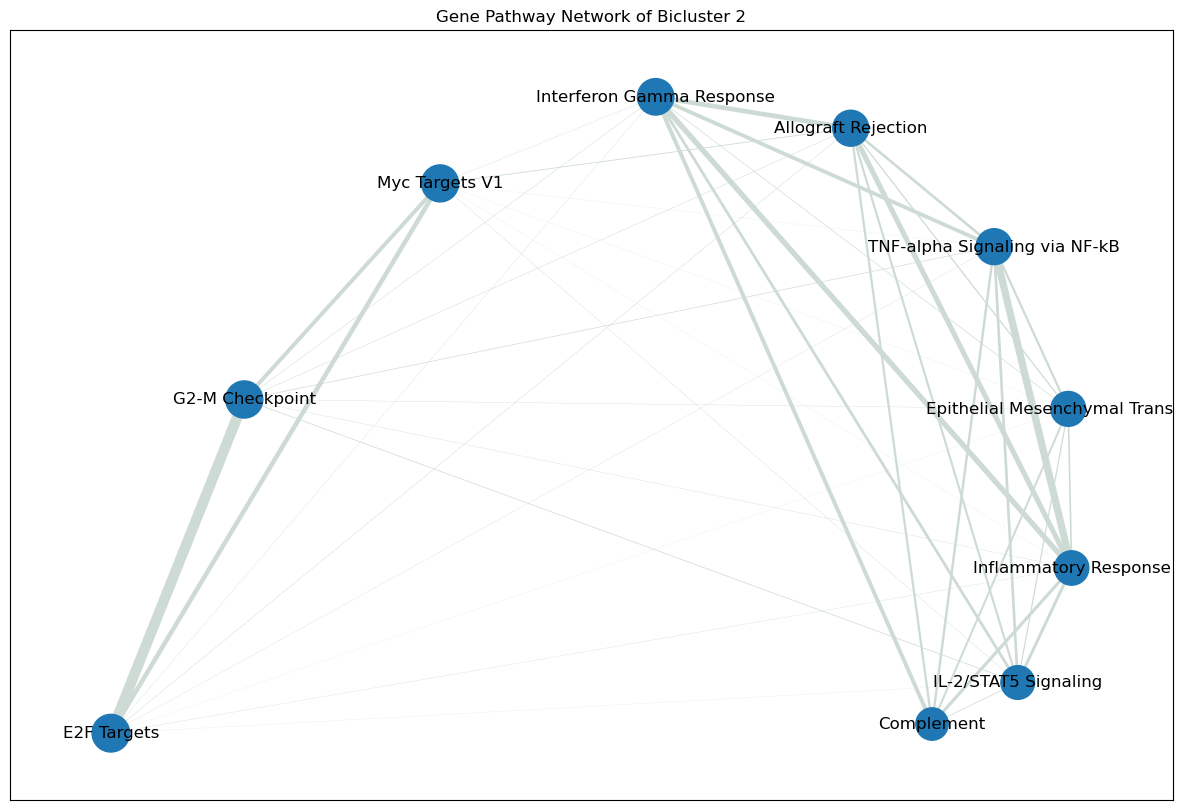

In [148]:
#Code modified From gseapy documentation
from gseapy import prerank
from gseapy import enrichment_map
import networkx as nx

nodes, edges = enrichment_map(enr.res2d)
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

fig, ax = plt.subplots(figsize=(15, 10))

# init node cooridnates
pos=nx.layout.spiral_layout(G)
#node_size = nx.get_node_attributes()
# draw node
nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.RdYlBu,
                       node_size=list(nodes.Hits_ratio *1000))
# draw node label
nx.draw_networkx_labels(G,
                        pos=pos,
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*30, edge_weight)),
                       edge_color='#CDDBD4')

plt.title("Gene Pathway Network of Bicluster 2")
plt.show()

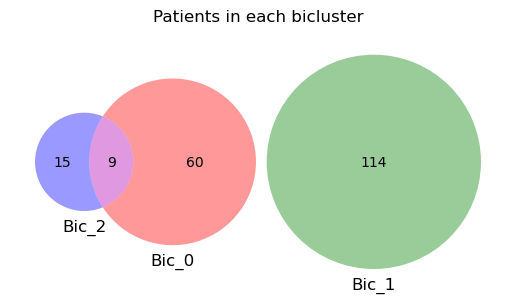

In [168]:
#Plotting venn_diagrams patients in each of the biclusters
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

patients0=set(isa2norm.biclusters[0].cols)
patients1=set(isa2norm.biclusters[1].cols)
patients2=set(isa2norm.biclusters[2].cols)

venn3([patients0,patients1,patients2], ("Bic_0", "Bic_1", "Bic_2"))

plt.title("Patients in each bicluster")
plt.show()

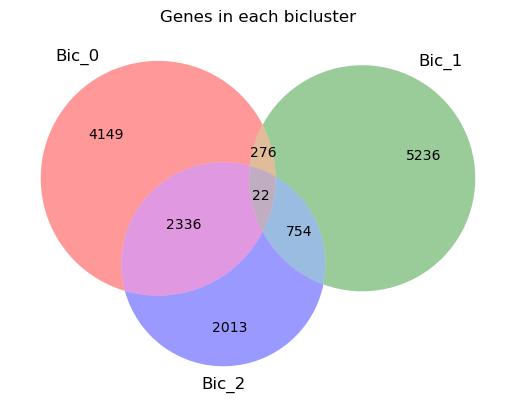

In [169]:
#Plotting venn_diagrams genes in each of the biclusters
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles

patients0=set(isa2norm.biclusters[0].rows)
patients1=set(isa2norm.biclusters[1].rows)
patients2=set(isa2norm.biclusters[2].rows)

venn3([patients0,patients1,patients2], ("Bic_0", "Bic_1", "Bic_2"))

plt.title("Genes in each bicluster")
plt.show()

In [149]:
#Exploring clinical features of each bicluster
#Defining the patients barcodes in each bicluster
patients_bic0=merged1.iloc[isa2norm.biclusters[0].cols].index
patients_bic1=merged1.iloc[isa2norm.biclusters[1].cols].index
patients_bic2=merged1.iloc[isa2norm.biclusters[2].cols].index

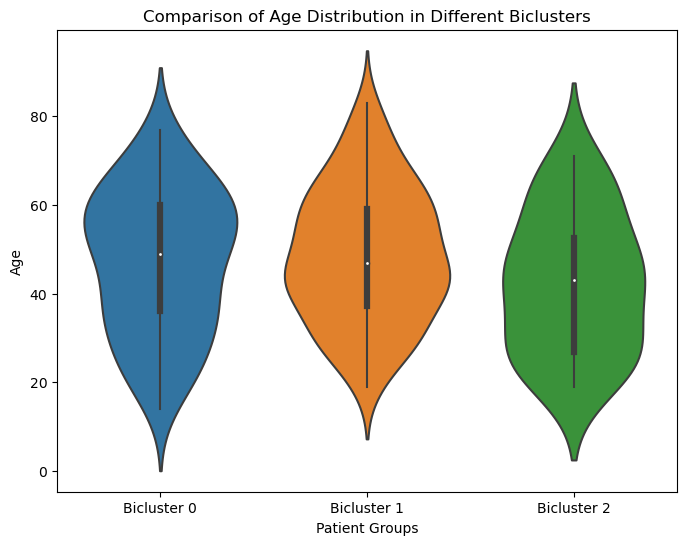

In [161]:
#Comparing the age distributions of patients in different biclusters
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

group_names = ["Bicluster 0", 'Bicluster 1', 'Bicluster 2']
group_a_ages = clinical1.loc[patients_bic0]["yearstobirth"].astype(float).tolist()
group_b_ages = clinical1.loc[patients_bic1]["yearstobirth"].astype(float).tolist()
group_c_ages = clinical1.loc[patients_bic2]["yearstobirth"].astype(float).tolist()

#DF with the ages
data = pd.DataFrame({
    'Group': ["Bicluster 0"] * len(group_a_ages) + ['Bicluster 1'] * len(group_b_ages) + ['Bicluster 2'] * len(group_c_ages),
    'Age': group_a_ages + group_b_ages + group_c_ages
})

plt.figure(figsize=(8, 6))
sns.violinplot(x='Group', y='Age', data=data)
plt.title('Comparison of Age Distribution in Different Biclusters')
plt.xlabel('Patient Groups')
plt.ylabel('Age')
plt.show()

In [173]:
np.mean(clinical1.loc[patients_bic2]["yearstobirth"].astype(float))

42.291666666666664

###Random Survival Forest for Survival Analysis

In [6]:
!pip install scikit-survival


Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 816.9/816.9 kB 12.8 MB/s eta 0:00:00
     ---------------------------------------- 9.3/9.3 MB 32.9 MB/s eta 0:00:00
     ------------------------------------- 292.9/292.9 kB 18.8 MB/s eta 0:00:00
     ---------------------------------------- 72.0/72.0 kB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 85.1/85.1 kB 4.7 MB/s eta 0:00:00


In [149]:
from sksurv.ensemble import RandomSurvivalForest

In [72]:

merged1['OS'].replace(-64, 64, inplace=True)

In [153]:
#Random Survival Test Using the merged1 DataFram containing the GEX and status/Overall Survival
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

# 1:3 Data split into training and Testing using Gene expression data and (Overall survival, status) as labels
X_train, X_test, y_train, y_test=train_test_split(merged1.iloc[:,2:], Surv.from_arrays(merged1.iloc[:,0], merged1.iloc[:,1]), test_size=0.33, random_state=0)


#RSF survival model as implemented by Sci-kit survival
# This RSF uses log-rank test at each split node compared to an impurity split such as in CART
rsf=RandomSurvivalForest(n_jobs=-1)
rsf.fit(X_train, y_train)

#Predict
c_index=rsf.score(X_test, y_test)

#OBTAIN THE CONCORDANCE INDEX WHICH ASSESS THE ABILITY OF THE ALGORITHM TO PREDICT COMPARABLE RISKS AMONG THE TEST SET.
print(c_index)

0.9318479685452162


In [154]:
#Structure of the test data survival "labels"
y_test

array([(False, 1090.), (False, 1080.), ( True,  579.), ( True,  994.),
       (False,  191.), ( True,  562.), (False,  679.), (False,   37.),
       (False, 1589.), (False, 1497.), (False, 2379.), (False,   43.),
       (False, 1540.), (False,  727.), ( True, 1677.), (False, 1493.),
       (False,  723.), (False, 1167.), (False,  816.), ( True,  662.),
       (False, 1414.), (False, 2161.), ( True,  490.), (False,  383.),
       (False,  405.), (False, 3293.), ( True,  125.), (False,  959.),
       (False,  928.), (False, 3880.), ( True, 1750.), (False,  741.),
       (False,  132.), (False, 1102.), (False, 2091.), ( True,  755.),
       (False,  604.), ( True,  383.), (False,  762.), (False, 3384.),
       (False,  464.), ( True,  159.), (False, 2832.), (False,  606.),
       (False, 3323.), (False,   32.), (False,  579.), (False, 1858.),
       (False, 1394.), (False,  885.), (False, 3247.), (False, 2202.),
       ( True,  344.), (False,  828.), (False,  538.), (False, 3138.),
      

In [155]:
#Permutation Feature importance to find the most important genes
from sklearn.inspection import permutation_importance

# 5 repeats of the permutation per feature
result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

In [164]:
#Get a list of the most important genes
#Sample code modified from documentation of sci-kit survival
import pandas as pd
feature_importance=pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

In [225]:
feature_importance.head()

,importances_mean,importances_std
SETD8,0.005242,0.001853
PCSK1,0.004980,0.001284
AIG1,0.004718,0.000642
AMPD3,0.004456,0.000642
BIRC5,0.004456,0.001337


In [56]:
y_test

array([( True, 1.750e+03), (False, 1.301e+03), (False, 4.673e+03),
       (False, 7.360e+02), (False, 3.347e+03), (False, 9.634e+03),
       (False, 1.110e+02), (False, 7.190e+02), (False, 1.317e+03),
       (False, 5.610e+02), ( True, 5.790e+02), (False, 1.288e+03),
       (False, 1.292e+03), (False, 5.460e+02), (False, 1.414e+03),
       ( True, 1.204e+03), (False, 4.628e+03), (False, 2.214e+03),
       (False, 8.710e+02), (False, 2.895e+03), (False, 7.000e+00),
       (False, 1.920e+02), (False, 5.790e+02), (False, 1.080e+03),
       (False, 1.360e+02), (False, 3.000e+00), (False, 2.600e+01),
       (False, 8.610e+02), (False, 3.950e+02), (False, 1.271e+03),
       (False, 2.643e+03), ( True, 1.355e+03), (False, 1.630e+03),
       ( True, 5.410e+02), (False, 1.136e+03), (False, 1.201e+03),
       (False, 2.740e+02), (False, 1.133e+03), (False, 1.493e+03),
       (False, 1.167e+03), ( True, 9.500e+01), (False, 1.029e+03),
       (False, 3.980e+02), (False, 7.270e+02), (False, 1.031e+

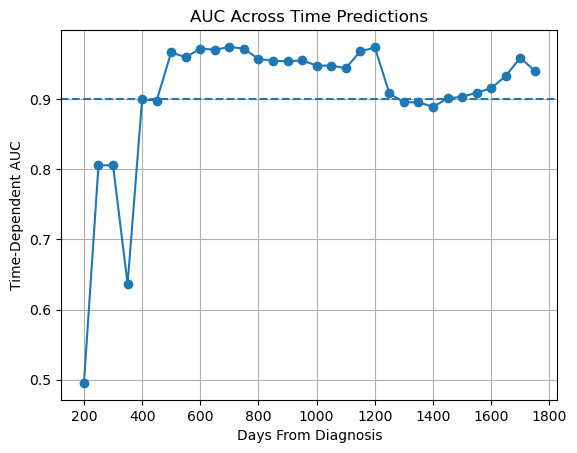

In [223]:
#An option to assess the random suvival model is through time dependent area under the curve within a given interval of time. 
# For predicting survival within the first 5-years the model is good with an average AUC ~0.9 
#Sample code modified from scikit survival documentation
import numpy as np
from sksurv.metrics import cumulative_dynamic_auc
va_times = np.arange(200, 1800, 50)

rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)


plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Days From Diagnosis")
plt.ylabel("Time-Dependent AUC")
plt.title("AUC Across Time Predictions")
plt.grid(True)